In [3]:
import datasets as ds
from redditqa.data.smart_filter import question_filter
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-13 10:17:22.652510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 10:17:22.652589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 10:17:22.887534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 10:17:23.561811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to 

In [4]:
dataset = ds.load_from_disk("/scratch1/redditqa/cached_datasets/AskHistorians_question_filter_probabilities.jsonl")

In [5]:
dataset[0]["graded_output"]

[{'probability': 5.414398884795446e-08, 'token_id': 9780, 'token_str': 'yes'},
 {'probability': 3.878222742059734e-06, 'token_id': 1510, 'token_str': 'no'},
 {'probability': 5.9029262047261e-05, 'token_id': 5613, 'token_str': 'Yes'},
 {'probability': 0.006459745578467846, 'token_id': 2501, 'token_str': 'No'},
 {'probability': 2.7870935781493245e-08, 'token_id': 28724, 'token_str': 'y'},
 {'probability': 3.152028327235712e-08, 'token_id': 28711, 'token_str': 'n'},
 {'probability': 0.6537843346595764,
  'token_id': 1014,
  'token_str': 'generated: The'}]

In [6]:
def parse_graded_output(row):
    graded_output = {
        entry["token_str"]: entry["probability"]
        for entry in row["graded_output"]
    }
    return {"prob_good": max(graded_output["Yes"], graded_output["yes"], graded_output["y"]), 
            "prob_bad": max(graded_output["No"], graded_output["no"], graded_output["no"])}

dataset = dataset.map(parse_graded_output, batched=False, load_from_cache_file=False)

Map: 100%|██████████| 69262/69262 [00:14<00:00, 4652.71 examples/s]


In [7]:
df = pd.DataFrame.from_dict({
    "prob_good": dataset["prob_good"],
    "prob_bad": dataset["prob_bad"]
})

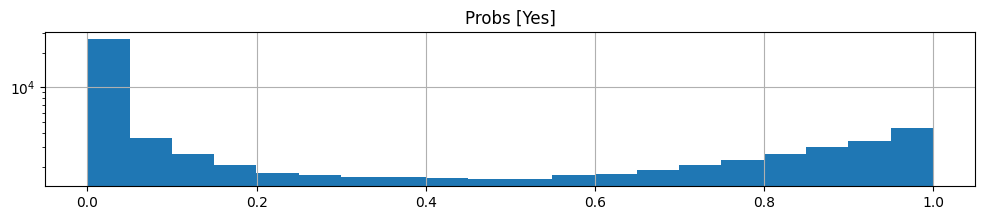

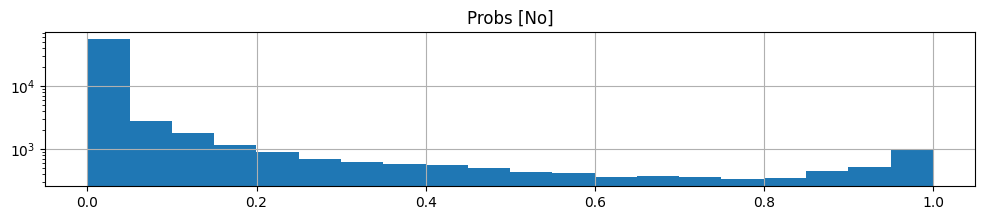

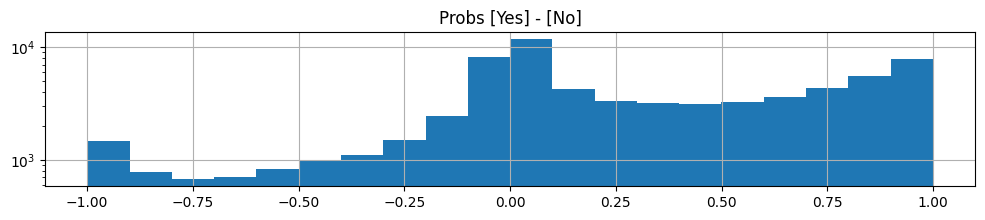

In [8]:
df.prob_good.hist(bins=20, log=True, figsize=(12, 2))
plt.title("Probs [Yes]")
plt.show()
df.prob_bad.hist(bins=20, log=True, figsize=(12, 2))
plt.title("Probs [No]")
plt.show()
(df.prob_good - df.prob_bad).hist(bins=20, log=True, figsize=(12, 2))
plt.title("Probs [Yes] - [No]")
plt.show()

In [9]:
quantiles = (df.prob_good - df.prob_bad).quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
quantiles

0.1   -0.274939
0.2   -0.031380
0.3    0.001499
0.4    0.052628
0.5    0.194914
0.6    0.404778
0.7    0.619343
0.8    0.791011
0.9    0.913311
dtype: float64

In [10]:
dataset_filtered = dataset.filter(lambda row: row["prob_good"] > quantiles[0.8])
dataset_filtered

Filter: 100%|██████████| 69262/69262 [00:05<00:00, 13086.97 examples/s]


Dataset({
    features: ['question_created_utc', 'question_retrieved_on', 'question_deleted', 'question_title', 'question_selftext', 'question_score', 'question_char_length', 'question_selftext_char_length', 'answers', 'graded_output', 'prob_good', 'prob_bad'],
    num_rows: 13860
})

In [11]:
pd.Series(dataset_filtered["prob_good"]).describe()

count    13860.000000
mean         0.907099
std          0.060710
min          0.791013
25%          0.856306
50%          0.913233
75%          0.962063
max          0.999216
dtype: float64

In [12]:
dataset_filtered["question_title"]

['Are there any Major or semi- major generally accepted historic events that we only know about due to secondary sources?',
 'What are the most common and prevalent existence of paradigms in historiography, and how do they affect the study of history?',
 'Who were some of the most corrupt Popes and clergymen in history?',
 'Why were medieval/early modern Christian philosophers so focused on ancient Greek pagan philosophers, specifically Plato and Aristotle?',
 'Religious sects of Reformation England: Who were they and what did they believe?',
 'How did the Roman government react to the eruption of Mt. Vesuvius in AD 79?',
 'Is there any other instance in history where a different race of people were imported into a land as slaves and eventually became fully assimilated as equals into society? If so how long did it take? ',
 "How were the United States' capitals picked? Did they naturally arise from large cities, or was there some sort of deliberation? If so, what is taken into consider

In [13]:
interesting_samples = [
    'I started /r/Simulate, a new idea collective dedicated to dreaming the most realistic geopolitical history simulator ever and playing it as a 4X strategy game. Can you submit some sources dedicated to quantitative methods of modeling history or any era?',
    "Has there ever been a case of a government completely restarting it's bureaucracy, without something like a revolution?"
]
dataset_filtered.filter(lambda row: row["question_title"] in interesting_samples)[0]

Filter: 100%|██████████| 13860/13860 [00:01<00:00, 11844.89 examples/s]


IndexError: Invalid key: 0 is out of bounds for size 0

In [14]:
from redditqa.data import dataset_split

import importlib
importlib.reload(dataset_split)

dataset_split.split_dataset(dataset_filtered)

Filter: 100%|██████████| 13860/13860 [00:01<00:00, 11862.49 examples/s]


DatasetDict({
    train: Dataset({
        features: ['question_created_utc', 'question_retrieved_on', 'question_deleted', 'question_title', 'question_selftext', 'question_score', 'question_char_length', 'question_selftext_char_length', 'answers', 'graded_output', 'prob_good', 'prob_bad'],
        num_rows: 8296
    })
    eval: Dataset({
        features: ['question_created_utc', 'question_retrieved_on', 'question_deleted', 'question_title', 'question_selftext', 'question_score', 'question_char_length', 'question_selftext_char_length', 'answers', 'graded_output', 'prob_good', 'prob_bad'],
        num_rows: 2778
    })
    test: Dataset({
        features: ['question_created_utc', 'question_retrieved_on', 'question_deleted', 'question_title', 'question_selftext', 'question_score', 'question_char_length', 'question_selftext_char_length', 'answers', 'graded_output', 'prob_good', 'prob_bad'],
        num_rows: 2797
    })
})